github link: https://github.com/NB-Uni/astron1221project3.git

In [1]:
from scipy.optimize import curve_fit, fsolve
from astroquery.vizier import Vizier
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
from astropy import constants as const

num_of_data_points = 25 #how many data points to use in this project

In [2]:
rv_data = Vizier(catalog="J/AJ/153/138").query_constraints()[0] #only need data in index 0
rv_data = rv_data[-num_of_data_points:] #uses most recent data; cuts off first data points

the above code gets the catalog data for this study of 51 Peg: https://ui.adsabs.harvard.edu/abs/2017yCat..51530138B/abstract
the catalog contains measurements of the radial velocity, uncertainty, and time in julidan date
limits data points to amount set earlier

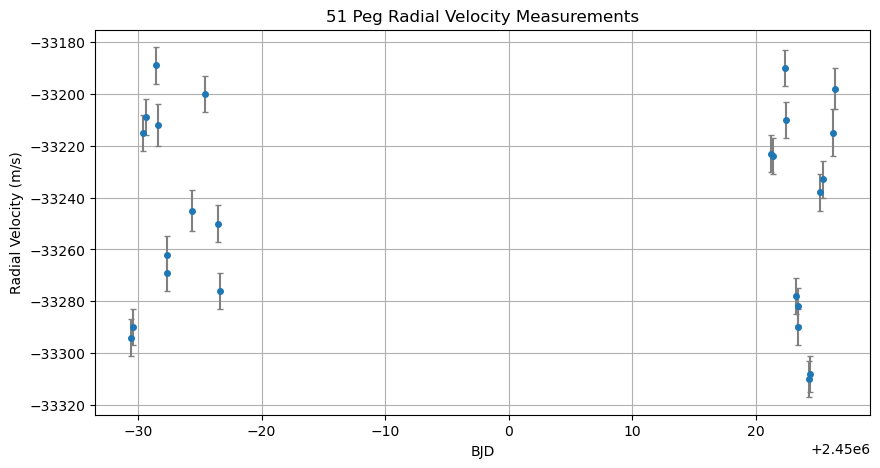

In [3]:
plt.figure(figsize=(10,5))
plt.errorbar(
    rv_data["BJD"],       # x: time
    rv_data["RV"],        # y: radial velocity
    yerr=rv_data["e_RV"], # error bars
    fmt='o',            # circle markers
    ecolor='gray',      # color of error bars
    capsize=2,          # little horizontal caps on error bars
    markersize=4
)

plt.xlabel("BJD")
plt.ylabel("Radial Velocity (m/s)")
plt.title("51 Peg Radial Velocity Measurements")
plt.grid(True)
plt.show()

Here, the radial velocity measurements are plotted against time.

In [4]:
def rv_model(t, vsys, K, P, t0): #define radial velocity model with 4 parameters
    phase = 2 * np.pi * (t - t0) / P
    return vsys - (K * np.sin(phase))

in the above model function, K is the wobble amplitude in m/s, P is the orbital period in days, t0 is the time offset,
t is time of observation, and vsys is the stars average velocity. returns radial velocity in m/s

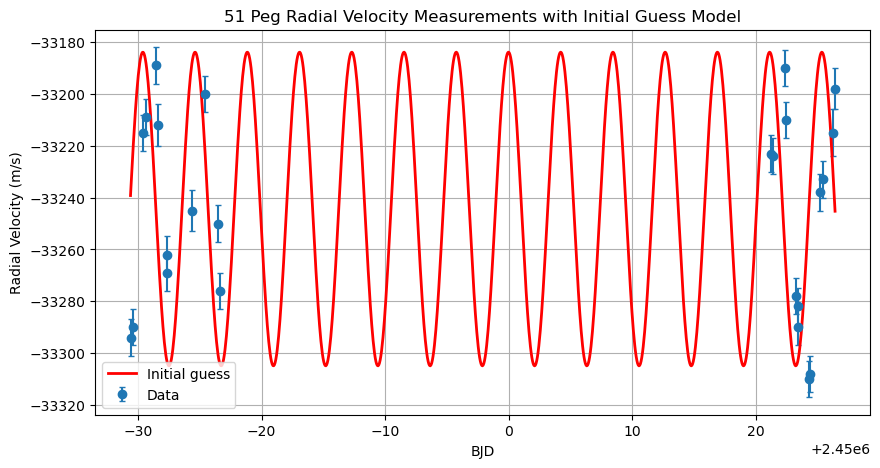

In [5]:
t_obs = rv_data["BJD"]
rv_obs = rv_data["RV"]
rv_err = rv_data["e_RV"]
t_model = np.linspace(t_obs.min(), t_obs.max(), 1000)


first_vsys = np.mean(rv_obs) #first guess for vsys will just be average RV
first_K = (np.max(rv_obs) - np.min(rv_obs)) / 2 #first guess for amplitude will be half the peak range
first_P = 4.23 #known period of 51 Peg b
first_t0 = t_obs[np.argmax(rv_obs)] #use first RV maximum in data for t0 guess
first_guess = rv_model(t_model, first_vsys, first_K, first_P, first_t0)

plt.figure(figsize=(10,5))
plt.errorbar(t_obs, rv_obs, yerr=rv_err, fmt='o', label='Data', capsize=2)
plt.plot(t_model, first_guess, color='red', label='Initial guess', linewidth=2)
plt.xlabel("BJD")
plt.ylabel("Radial Velocity (m/s)")
plt.title("51 Peg Radial Velocity Measurements with Initial Guess Model")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
print(first_vsys)
print(first_K)
print(first_P)
print(first_t0)

-33244.4
60.5
4.23
2449971.441218


In [7]:
first_model_vals = rv_model(t_obs, first_vsys, first_K, first_P, first_t0)
first_chi2 = np.sum(((rv_obs-first_model_vals)/rv_err)**2)
print(first_chi2)
num_of_params = 4 #4 parameters
dof = num_of_data_points - num_of_params
print(dof)
first_redchi2 = first_chi2/dof
print(first_redchi2)

1057.7730935147301
21
50.37014731022524


The above code uses reduced chi squared to judge how well the initial guess fits. This is explained more later, but the result value of 50 is not good at all and indicated that the curve defined by the first guess parameters is not very accurate.

In [8]:
p0 = [first_vsys, first_K, first_P, first_t0]
popt, pcov = curve_fit(rv_model, t_obs, rv_obs, p0=p0, sigma=rv_err)
opt_vsys = popt[0]
opt_K = popt[1]
opt_P = popt[2]
opt_t0 = popt[3]


use scipy curve_fit to get optimal parameters

In [9]:
print(opt_vsys)
print(opt_K)
print(opt_P)
print(opt_t0)

-33252.7804100898
58.15627827557255
4.240344780663259
2449972.172316282


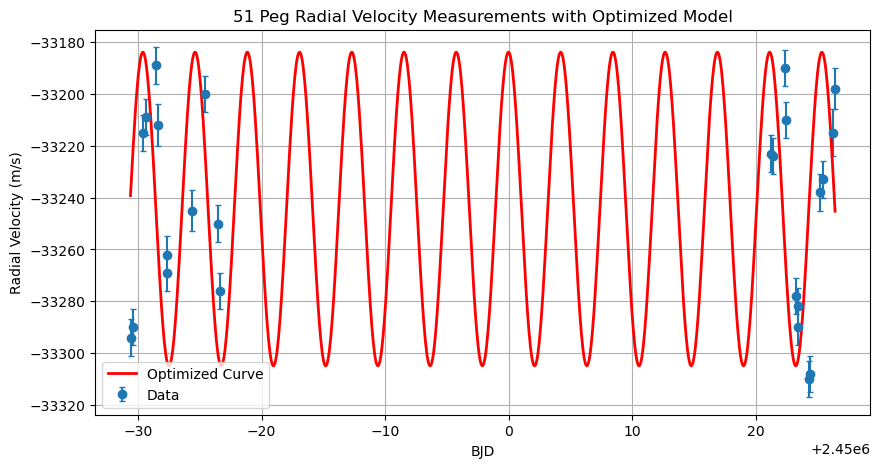

In [10]:
t_model = np.linspace(t_obs.min(), t_obs.max(), 1000)
optimized_guess = rv_model(t_model, opt_vsys, opt_K, opt_P, opt_t0)

plt.figure(figsize=(10,5))
plt.errorbar(t_obs, rv_obs, yerr=rv_err, fmt='o', label='Data', capsize=2)
plt.plot(t_model, first_guess, color='red', label='Optimized Curve', linewidth=2)
plt.xlabel("BJD")
plt.ylabel("Radial Velocity (m/s)")
plt.title("51 Peg Radial Velocity Measurements with Optimized Model")
plt.legend()
plt.grid(True)
plt.show()

This plot shows the radial velocity of 51 Peg as a sin wave. It uses scipy's optimized parameters

In [11]:
model_vals = rv_model(t_obs, opt_vsys, opt_K, opt_P, opt_t0)
chi2 = np.sum(((rv_obs-model_vals)/rv_err)**2)
print(chi2)
num_of_params = 4 #4 parameters
dof = num_of_data_points - num_of_params
print(dof)
redchi2 = chi2/dof
print(redchi2)

22.330354243804983
21
1.0633502020859515


Above, the accuracy of the optimized model is tested. First chi squared is calculated by using the actual data points and what the model predicts those data points will look like. Then it is reduced by the degrees of freedom, which is equal to the amount of data points minus the parameters. This calculates the reduced chi squared.
Since the reduced value is close to 1, that means that the model is a good fit and the uncertainties are accurate.

In [12]:
p_sec = opt_P * 24 * 60 * 60 #convert period to seconds
f_m = (p_sec * opt_K**3)/(2 * np.pi * const.G.value)
f_m = f_m / const.M_sun.value #convert to solar masses

def mass_function_equation(M2, f_M, M1, sin_i):
    left = f_M * (M1 + M2)**2
    right = (M2 * sin_i)**3
    return left - right  # Returns 0 at solution

#Assumptions: Mass of 51 Peg (M1) is 1 solar masses, i = 90 degrees
M1 = 1
sin_i = 1
initial_guess = 0.001 #initial guess is based on jupiters mass in solar masses
M2 = fsolve(mass_function_equation, initial_guess, args=(f_m, M1, sin_i))[0] #retrieves 51 Peg b (M2) mass in solar masses
print(M2)

0.0004422478786084624


The above code uses the mass function to find the mass of both 51 Peg and 51 Peg b. To do this, it first calculates the value f(M) from the period and amplitude of 51 Peg's radial velocity. This is the value that the other half of the equation, the half with the masses of the star and planet, must be equal to. f(M) is calculated by (PK^3)/(2piG) where G is the gravitional constant that converts those units into mass.
After we calculate f(M), we rearrange the mass function to equal 0 and provide a model for this. Scipy.optimize.fsolve will find the necessary values to equal 0. This gives us the minimum mass of 51 Peg b in solar masses.

51 Peg b's mass is calculated here at minimum 0.00043680107870117135 solar masses, or 8.687624019502891e+26 kilograms, depending on sin i. That makes it a little less than half the mass of Jupiter. This is surprising because its orbital period is only 4.23 days, much less than Jupiter's orbital period of 12 years. This shorter period shows a much closer proximity to its star, 51 Peg, and combined with its high mass makes 51 Peg b a "hot Jupiter" planet.

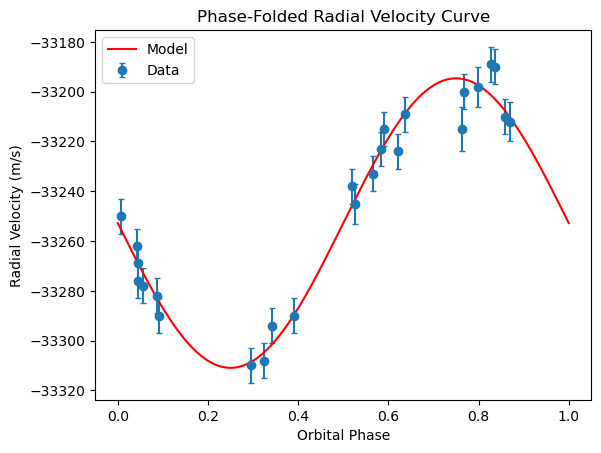

In [13]:
phase = ((t_obs - opt_t0) / opt_P) % 1 # Compute phases (0 to 1)

sorted_idx = np.argsort(phase) #sort by phase for plotting a smooth curve
phase_sorted = phase[sorted_idx]
rv_obs_sorted = rv_obs[sorted_idx]
rv_err_sorted = rv_err[sorted_idx]

phase_model = np.linspace(0, 1, 1000)
t_model = phase_model * opt_P + opt_t0
rv_model_curve = rv_model(t_model, opt_vsys, opt_K, opt_P, opt_t0) #generate model curve for plotting

#plot data and model
plt.errorbar(phase, rv_obs, yerr=rv_err, fmt='o', label='Data', capsize=2)
plt.plot(phase_model, rv_model_curve, color='red', label='Model')
plt.xlabel("Orbital Phase")
plt.ylabel("Radial Velocity (m/s)")
plt.title("Phase-Folded Radial Velocity Curve")
plt.legend()
plt.show()

This graph shows radial velocity not by time but orbital phase.

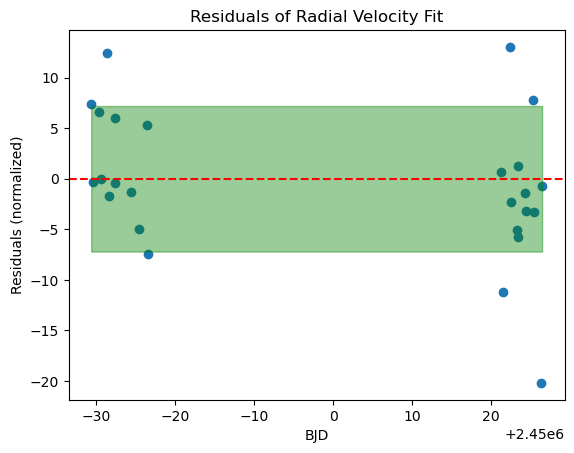

In [14]:
rv_model_vals = rv_model(t_obs, opt_vsys, opt_K, opt_P, opt_t0) #get values predicted by model

residuals = rv_obs - rv_model_vals

residuals_norm = residuals / rv_err #normalize residuals
avg_err = sum(rv_err) / len(rv_err)

#plot residuals
plt.scatter(t_obs, residuals)
plt.axhline(0, color='red', linestyle='--') #zero line

plt.fill_between(np.linspace(t_obs[0], t_obs[-1], 1000), -avg_err, avg_err, alpha=0.4, color = 'green', label = 'Within 1 standard error' )
plt.xlabel("BJD")
plt.ylabel("Residuals (normalized)")
plt.title("Residuals of Radial Velocity Fit")
plt.show()

This graph shows the residuals from the optimized curve. The residuals represent how much the model's predicted value differed from the actual value. The green section shows which residuals are within 1 average error from the model. These data points are within the acceptable range.